In [1]:
println(VERSION, " (", Sys.CPU_NAME, ")")

1.7.2 (skylake)


In [2]:
struct Config
  diagnostics
  solver
  pusher
  interactions
  species
  grid
end

In [3]:
# + units and constants
using Unitful
↦(value::Unitful.Units, unit::Unitful.Units) = Unitful.convfact(unit, value)
↦(value::Unitful.Quantity, unit::Unitful.Units) = uconvert(unit, value).val

# units
const °C = u"°C"
const K  = u"K"  ↦ u"K"
const kB = u"k"  ↦ u"J/K"
const C  = u"C"  ↦ u"C"
const V  = u"V"  ↦ u"V"
const m  = u"m"  ↦ u"m"
const cm = u"cm" ↦ u"m"
const u  = u"u"  ↦ u"kg"
const s  = u"s"  ↦ u"s"
const ms = u"ms" ↦ u"s"
const ns = u"ns" ↦ u"s"
const ps = u"ps" ↦ u"s"
const μs = u"μs" ↦ u"s"
const kV = u"MV" ↦ u"V"
const MV = u"MV" ↦ u"V"
const eV = u"eV" ↦ u"eV"
const kg = u"kg" ↦ u"kg"
const mps = u"m/s" ↦ u"m/s"
const kmps = u"km/s" ↦ u"m/s"
const kHz = u"kHz" ↦ u"Hz"
const MHz = u"MHz" ↦ u"Hz"

# constants
const ɛ0 = u"ɛ0" ↦ u"F/m"
const c0 = sqrt(u"1/ɛ0" * u"1/μ0") ↦ u"m/s"
const qe = 1.602_176_6208e-19C  # elementary charge
const me = 9.109_383_7015e-31kg # mass of electron
const mp = 1.672_621_8982e-27kg # mass of proton
nothing

In [4]:
function thermal_speed(T, m)
  sqrt(2kB*T/m)
end

thermal_speed (generic function with 1 method)

In [5]:
# + spatial and temporal paramters
const νtherm = thermal_speed(300K, me)
const νdrift = 1e7 #m/s
const mHe = 4.002602me/5.48579903e-04
const nHe = 1e24 # 1/m^3 number density
const ne = 1nHe
const f  = 9kHz # plasma frequency
const ω  = 2π * f * sqrt(2e-6ne)
const ds = 5e-3c0/ω
const ts = 1000
const nx = 256
const Δh = ds

const simulationVolume = nx * Δh
const numCells         = nx

const electronParticles    = 16 * numCells
const totalNumElectrons    = ne * simulationVolume
const electronNumRatio     = totalNumElectrons / electronParticles

Δt = .4Δh/νdrift/sqrt(2.0)
Lx = nx*Δh

println("Δt: ", Δt, "\nΔh: ", Δh, "\nLx: ", Lx)
println("νtherm: ", round(νtherm/c0; sigdigits=1), "c")
println("νdrift: ", round(νdrift/c0; sigdigits=3), "c")
println("electrons: ", electronParticles, " wg: ", electronNumRatio)

Δt: 5.30149462137438e-16
Δh: 1.8743613985989163e-8
Lx: 4.798365180413226e-6
νtherm: 0.0003c
νdrift: 0.0334c
electrons: 4096 wg: 1.1714758741243228e15


In [6]:
using StaticArrays
include("ParticleInCell/src/pic/kinetic.jl");

In [7]:
# + species and sources
const e   = KineticSpecies{1,3}(:e,  20_000, -1qe, 1me,  electronNumRatio)
const iHe = KineticSpecies{1,3}(:iHe, 20_000, +1qe, 1mHe, electronNumRatio)

include("ParticleInCell/src/pic/sources.jl")
const fwd = MaxwellianSource{1,3}(electronParticles/2/Δt, [Lx,], [νtherm,νtherm,νtherm], dv=[+νdrift,0.,0.])
const rev = MaxwellianSource{1,3}(electronParticles/2/Δt, [Lx,], [νtherm,νtherm,νtherm], dv=[-νdrift,0.,0.])

const species = [e, iHe]

2-element Vector{KineticSpecies{1, 3}}:
 e
 iHe

In [8]:
using LinearAlgebra
using Statistics
using SparseArrays
include("pole/boundary_conditions.jl")
include("pole/gradient.jl")
include("pole/iterative_methods.jl")
include("pole/inplace_periodic_solver.jl")
include("pole/linear_solver.jl")
include("pole/linear_solver1.jl")

solution(ps::InPlacePeriodicSolver) = ps.u
gradient(ps::InPlacePeriodicSolver) = let periodic = PeriodicBC()
    GradientOperator(ps.nx, ps.δx, (periodic, periodic))
end

solution(ps::LinearSolver) = reshape(ps.u, ps.n...)
gradient(ps::LinearSolver) = GradientOperator(ps.n[1], ps.δ[1], ps.bcs)

function create_poisson_solver(grid, ε0)
    xf, = grid.coords
    ps = LinearSolver(xf; left=PeriodicBC(), right=PeriodicBC())
end

function calculate_electric_potential(ps, f)
    @inbounds for i in eachindex(f)
      f[i] /= ε0
    end
    solve!(ps, f)
    φ  = solution(ps)
end

calculate_electric_potential (generic function with 1 method)

In [9]:
using LinearAlgebra, StaticArrays
const xs = 0m:Δh:Lx
include("RegularGrids/src/uniform_grid.jl")
include("ParticleInCell/src/pic/pushers.jl")
const grid    = create_uniform_grid(xs)
const solver  = create_poisson_solver(grid, ε0)
const pusher  = create_boris_pusher(species)
nothing

In [10]:
include("ParticleInCell/src/pic/wrap.jl")
function after_push(part, grid)
  wrap!(part, grid, @SVector[1.0], 1)
end

function enter_loop() # uses global: e, iHe, fwd, rev
  e.np = 0
  sample!(fwd, e, Δt)
  sample!(rev, e, Δt)
  # place ions in the same positions as electrons
  iHe.x .= e.x
  iHe.v .= zero(e.v)
  iHe.np = e.np
end

enter_loop (generic function with 1 method)

In [93]:
using Random; Random.seed!(0)

function after_loop(i, t, dt) end
function exit_loop() end

const diagnostics = Dict{String, Array{Float64, 2}}(
    "ne-"  => zeros(nx, ts),
    "nHe+" => zeros(nx, ts),
    "rho"  => zeros(nx, ts),
    "phi"  => zeros(nx, ts),
    "Ex"   => zeros(nx+1, ts),
    "Jx"   => zeros(nx+1, ts))

const config = Config(diagnostics, solver, pusher, [], species, grid)
println("[*] Running simulation")

struct FluidSpecies end
include("ParticleInCell/src/pic/algorithm.jl")
include("ParticleInCell/src/pic/cloud_in_cell.jl")
@time solve(config, Δt, 5)
@time solve(config, Δt, ts)

[*] Running simulation
e vel: 1.0015519830172507e7 => -1.6420262777775282e7
e pos: 3.235917521078514e-8 => 2.3653981730992178e-8
e wrap: 0.0 x: [2.3653981730992178e-8] [0.0]
iHe vel: 0.0 => 50653.880916238886
iHe pos: 3.235917521078514e-8 => 3.238602933850806e-8
iHe wrap: 0.0 x: [3.238602933850806e-8] [0.0]
e vel: -1.6420262777775282e7 => -4.285253964516083e7
e pos: 2.3653981730992178e-8 => 9.357308868869253e-10
e wrap: 0.0 x: [9.357308868869253e-10] [0.0]
iHe vel: 50653.880916238886 => 101307.14151217513
iHe pos: 3.238602933850806e-8 => 3.243973726509142e-8
iHe wrap: 0.0 x: [3.243973726509142e-8] [0.0]
e p: 1190 id: 1190
e i: 1 x: [9.357308868869253e-10] v: [-4.285253964516083e7, -27061.481622300213, 203141.4849187206]


LoadError: BoundsError: attempt to access 257-element Vector{Float64} at index [0]

In [92]:
include("ParticleInCell/src/pic/pushers.jl")
include("ParticleInCell/src/pic/wrap.jl")

wrap! (generic function with 1 method)

In [43]:
import Pkg
Pkg.activate(".")
Pkg.add("PyPlot")
Pkg.resolve()

  Activating project at `~/iskra`
   Resolving package versions...
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`
  No Changes to `~/iskra/Project.toml`
  No Changes to `~/iskra/Manifest.toml`


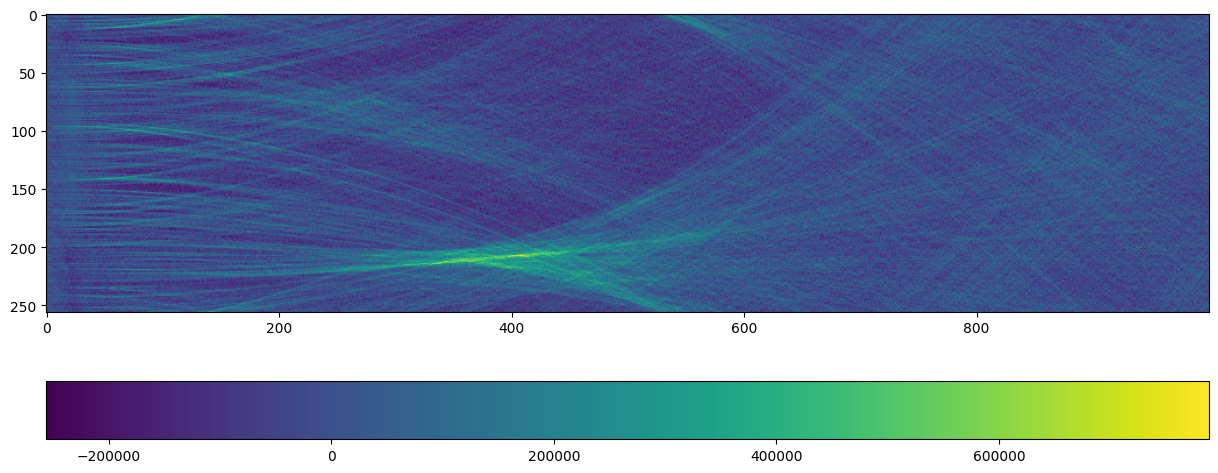

In [44]:
import PyPlot
PyPlot.figure(figsize=(15, 6))
PyPlot.imshow(diagnostics["rho"])
PyPlot.colorbar(orientation="horizontal");

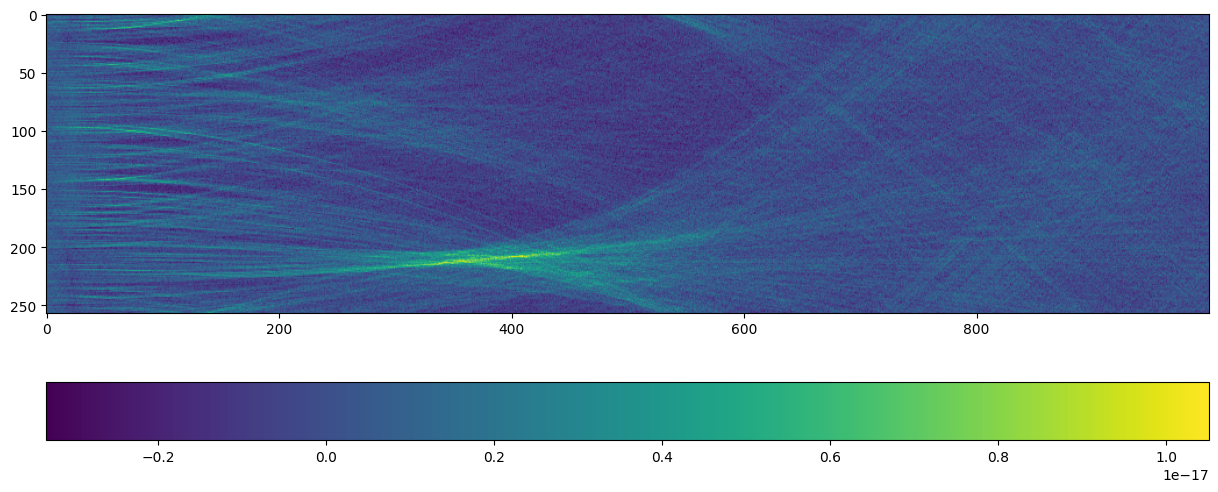

In [45]:
import PyPlot
PyPlot.figure(figsize=(15, 6))
PyPlot.imshow(diagnostics["Jx"])
PyPlot.colorbar(orientation="horizontal");

In [49]:
it = 400
Jx = diagnostics["Jx"][:,it]
ρ1 = diagnostics["rho"][:,it]
ρ2 = diagnostics["rho"][:,it+1]

256-element Vector{Float64}:
  -59012.194557640396
 -153668.0747295096
 -100700.47050391948
 -159989.40466560505
  -34015.76255413437
  -57208.3346910963
  -25783.767730163716
 -106078.68000096307
  -45269.639649425895
  -31871.393353424035
  -57702.3795636377
  -31853.189706808334
  -56757.74523013519
       ⋮
  -69567.6568457861
 -115941.15759023286
 -114211.92179428706
  -89304.96313400031
  -82057.26736016314
  -27986.475851174313
  -57896.12186066629
  -83514.10373586064
  -23786.490027134787
  -76000.7548850681
  -48411.97772576053
  -22924.519722869343

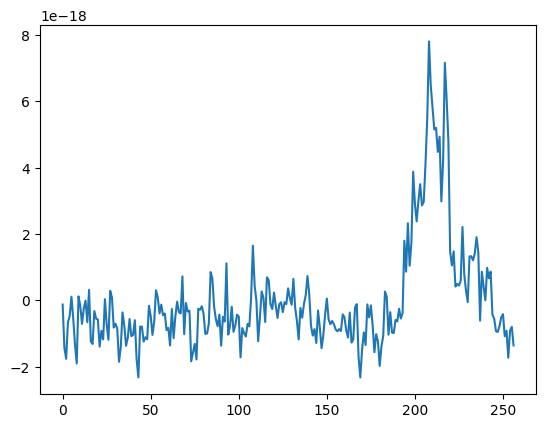

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb32d407650>

In [51]:
PyPlot.plot(Jx)

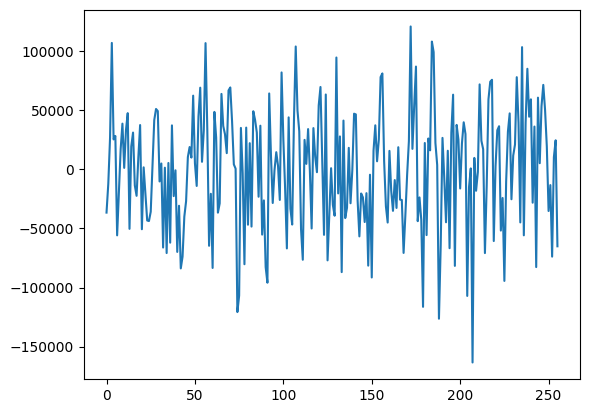

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb3348dab10>

In [54]:
PyPlot.plot(ρ1 - ρ2)